In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# library for extracting data
import time
import requests
import json
import ast
import googlemaps
from datetime import datetime
import re

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

---------------------------------------

### Extracting Data

In [2]:
# API_KEY = 'API_Key'
# gmaps = googlemaps.Client(key=API_KEY)

# def get_food_trucks_details(search_term):
#     # Perform an initial search using the provided search term
#     search_results = gmaps.places(query=search_term)
    
#     all_results = search_results.get('results', [])

#     # While there's a next_page_token, fetch the next set of results
#     while 'next_page_token' in search_results:
#         time.sleep(2)  # Wait for a short time before requesting the next page
#         search_results = gmaps.places(query=search_term, page_token=search_results['next_page_token'])
#         all_results.extend(search_results.get('results', []))
    
#     # Extract the place_id for each result to get its details
#     place_details_list = []
#     for result in all_results:
#         place_id = result['place_id']
#         place_details = gmaps.place(place_id=place_id, fields=[
#             'adr_address', 'business_status', 'formatted_address',
#             'geometry','name', 
#             'permanently_closed', 'photo', 'place_id', 'plus_code', 'type', 'url', 'utc_offset',
#             'vicinity', 'wheelchair_accessible_entrance', 'current_opening_hours', 
#             'formatted_phone_number', 'international_phone_number', 'opening_hours',
#             'secondary_opening_hours', 'website', 'curbside_pickup', 'delivery', 'dine_in',
#             'editorial_summary', 'price_level', 'rating', 'reservable', 'reviews',
#             'serves_beer', 'serves_breakfast', 'serves_brunch', 'serves_dinner',
#             'serves_lunch', 'serves_vegetarian_food', 'serves_wine', 'takeout', 'user_ratings_total'
#         ])
#         place_details_list.append(place_details['result'])
    
#     return place_details_list

# # Search for food trucks in Indianapolis
# food_trucks_details = get_food_trucks_details("food trucks indianapolis")

In [3]:
# len(food_trucks_details)

------------------------------------------

### Converting to a Dataframe

In [4]:
# df = pd.DataFrame(food_trucks_details)
# df.head()

In [5]:
## saving data to a csv
# df.to_csv('FoodTruckIndianapolis.csv', index = False)

-------------------------

### Collected Data Cleaning and Feature Extraction

#### Reading the data from the saved file

In [6]:
df = pd.read_csv('FoodTruckIndianapolis.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   adr_address                     60 non-null     object 
 1   business_status                 60 non-null     object 
 2   curbside_pickup                 27 non-null     object 
 3   current_opening_hours           51 non-null     object 
 4   formatted_address               60 non-null     object 
 5   formatted_phone_number          53 non-null     object 
 6   geometry                        60 non-null     object 
 7   international_phone_number      53 non-null     object 
 8   name                            60 non-null     object 
 9   opening_hours                   51 non-null     object 
 10  photos                          54 non-null     object 
 11  place_id                        60 non-null     object 
 12  plus_code                       60 non

#### Check for null values percentage

In [8]:
(df.isnull().sum() / len(df))*100

adr_address                        0.000000
business_status                    0.000000
curbside_pickup                   55.000000
current_opening_hours             15.000000
formatted_address                  0.000000
formatted_phone_number            11.666667
geometry                           0.000000
international_phone_number        11.666667
name                               0.000000
opening_hours                     15.000000
photos                            10.000000
place_id                           0.000000
plus_code                          0.000000
rating                             6.666667
reviews                            6.666667
serves_dinner                     20.000000
serves_lunch                      21.666667
takeout                            3.333333
types                              0.000000
url                                0.000000
user_ratings_total                 6.666667
utc_offset                         0.000000
vicinity                        

Curbside Pickup, Reservable, Price level, Serves Breakfast, Serves Vegetarian Food Serves Wine, Wheelchair Accessible Entrance and Serves Beer has > 50% null values.

Additionally, the cuisine is missing, from this. Google Places API does not have a field which will help with getting the fields, so will be trying something else.

#### Feature Selection

From the dataframe, we can drop certain features and rows.

First, let's drop the permanently closed restaurant.

In [9]:
df = df[~(df['permanently_closed']==True)]

We can also drop certain columns which are not going to be of much help, such as adr_address.

In [10]:
pd.set_option('display.max_columns', None) 
df.head()

,adr_address,business_status,curbside_pickup,current_opening_hours,formatted_address,formatted_phone_number,geometry,international_phone_number,name,opening_hours,photos,place_id,plus_code,rating,reviews,serves_dinner,serves_lunch,takeout,types,url,user_ratings_total,utc_offset,vicinity,delivery,dine_in,reservable,serves_beer,serves_wine,website,price_level,wheelchair_accessible_entrance,serves_breakfast,serves_vegetarian_food,editorial_summary,serves_brunch,secondary_opening_hours,permanently_closed
0,"<span class=""street-address"">8522 Madison Ave<...",OPERATIONAL,True,"{'open_now': False, 'periods': [{'close': {'da...","8522 Madison Ave, Indianapolis, IN 46227, USA",(317) 331-9921,"{'location': {'lat': 39.6427553, 'lng': -86.12...",+1 317-331-9921,big Jerry Indy food truck,"{'open_now': False, 'periods': [{'close': {'da...","[{'height': 1158, 'html_attributions': ['<a hr...",ChIJrZbSAjlda4gRzX8ft2gUhfw,"{'compound_code': 'JVVH+4W Indianapolis, IN, U...",5.0,"[{'author_name': 'Janet Bostian', 'author_url'...",True,True,True,"['restaurant', 'food', 'point_of_interest', 'e...",https://maps.google.com/?cid=18195972309441806285,1.0,-240,"8522 Madison Avenue, Indianapolis",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"<span class=""street-address"">3014 Lafayette Rd...",OPERATIONAL,NaN,"{'open_now': False, 'periods': [{'close': {'da...","3014 Lafayette Rd #3000, Indianapolis, IN 4622...",(317) 658-6970,"{'location': {'lat': 39.8099204, 'lng': -86.22...",+1 317-658-6970,Pico de Gallo Food Truck,"{'open_now': False, 'periods': [{'close': {'da...","[{'height': 3024, 'html_attributions': ['<a hr...",ChIJ5yom11tWa4gR1fqgVmHn10o,"{'compound_code': 'RQ5H+XG Indianapolis, IN, U...",4.5,"[{'author_name': 'fat “tre” folks', 'author_ur...",True,True,True,"['restaurant', 'food', 'point_of_interest', 'e...",https://maps.google.com/?cid=5393033484050692821,251.0,-240,"3014 Lafayette Road #3000, Indianapolis",False,True,False,False,False,https://www.facebook.com/peregrino1982/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"<span class=""street-address"">9130 E 38th St</s...",OPERATIONAL,True,"{'open_now': True, 'periods': [{'close': {'dat...","9130 E 38th St, Indianapolis, IN 46235, USA",(317) 895-9259,"{'location': {'lat': 39.8263944, 'lng': -86.00...",+1 317-895-9259,The Latin Flavor - Food Truck,"{'open_now': True, 'periods': [{'close': {'day...","[{'height': 3024, 'html_attributions': ['<a hr...",ChIJ1WvY2R5Ja4gRoI-kU1qn1Bc,"{'compound_code': 'RXGV+H7 Indianapolis, IN, U...",4.1,"[{'author_name': 'Drew “The Legend” Davis', 'a...",True,True,True,"['restaurant', 'food', 'point_of_interest', 'e...",https://maps.google.com/?cid=1717181364327190432,47.0,-240,"9130 East 38th Street, Indianapolis",True,True,True,NaN,NaN,http://thelatinflavorindy.com/?utm_source=gmb&...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"<span class=""street-address"">7910 Michigan Rd<...",OPERATIONAL,NaN,"{'open_now': False, 'periods': [{'close': {'da...","7910 Michigan Rd, Indianapolis, IN 46268, USA",(317) 431-4439,"{'location': {'lat': 39.89754269999999, 'lng':...",+1 317-431-4439,Mi Lindo Pénjamo - Food Truck,"{'open_now': False, 'periods': [{'close': {'da...","[{'height': 4032, 'html_attributions': ['<a hr...",ChIJG__HbklVa4gRYiCltEzZ5ps,"{'compound_code': 'VQXM+2C Indianapolis, IN, U...",4.5,"[{'author_name': 'Karter Bae', 'author_url': '...",True,True,True,"['restaurant', 'point_of_interest', 'food', 'e...",https://maps.google.com/?cid=11233905243993743458,26.0,-240,"7910 Michigan Road, Indianapolis",NaN,True,False,NaN,NaN,https://store.kahero.co/milindopenjamo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"<span class=""street-address"">7202 E Washington...",OPERATIONAL,NaN,NaN,"7202 E Washington St, Indianapolis, IN 46219, USA",(317) 490-2417,"{'location': {'lat': 39.77254509999999, 'lng':...",+1 317-490-2417,Super Tacos food truck,NaN,"[{'height': 1381, 'html_attributions': ['<a hr...",ChIJA1KNvZVPa4gRzYcJrty8Ews,"{'compound_code': 'QXF5+2V Indianapolis, IN, U...",4.6,"[{'author_n

In [11]:
df.columns

Index(['adr_address', 'business_status', 'curbside_pickup',
       'current_opening_hours', 'formatted_address', 'formatted_phone_number',
       'geometry', 'international_phone_number', 'name', 'opening_hours',
       'photos', 'place_id', 'plus_code', 'rating', 'reviews', 'serves_dinner',
       'serves_lunch', 'takeout', 'types', 'url', 'user_ratings_total',
       'utc_offset', 'vicinity', 'delivery', 'dine_in', 'reservable',
       'serves_beer', 'serves_wine', 'website', 'price_level',
       'wheelchair_accessible_entrance', 'serves_breakfast',
       'serves_vegetarian_food', 'editorial_summary', 'serves_brunch',
       'secondary_opening_hours', 'permanently_closed'],
      dtype='object')

In [12]:
df.drop(['adr_address', 'photos', 'place_id', 'plus_code', 'utc_offset', 'secondary_opening_hours', 'permanently_closed', 'vicinity', 'international_phone_number', 'url', 'current_opening_hours'], axis = 1, inplace = True)

We can now drop those columns which have more than 50% null values

In [13]:
(df.isnull().sum() / len(df))*100

business_status                    0.000000
curbside_pickup                   54.237288
formatted_address                  0.000000
formatted_phone_number            11.864407
geometry                           0.000000
name                               0.000000
opening_hours                     13.559322
rating                             6.779661
reviews                            6.779661
serves_dinner                     18.644068
serves_lunch                      20.338983
takeout                            1.694915
types                              0.000000
user_ratings_total                 6.779661
delivery                          25.423729
dine_in                           23.728814
reservable                        54.237288
serves_beer                       59.322034
serves_wine                       69.491525
website                           38.983051
price_level                       77.966102
wheelchair_accessible_entrance    66.101695
serves_breakfast                

In [14]:
# Detect columns with more than 50% null values
columns_to_drop = df.columns[df.isnull().mean() > 0.5]

# Drop those columns
df.drop(columns=columns_to_drop, inplace = True)

print(f"Dropped columns due to high amount of null values: {', '.join(list(columns_to_drop))}")

Dropped columns due to high amount of null values: curbside_pickup, reservable, serves_beer, serves_wine, price_level, wheelchair_accessible_entrance, serves_breakfast, serves_vegetarian_food, editorial_summary, serves_brunch


---------------------------------------

In [15]:
df

,business_status,formatted_address,formatted_phone_number,geometry,name,opening_hours,rating,reviews,serves_dinner,serves_lunch,takeout,types,user_ratings_total,delivery,dine_in,website
0,OPERATIONAL,"8522 Madison Ave, Indianapolis, IN 46227, USA",(317) 331-9921,"{'location': {'lat': 39.6427553, 'lng': -86.12...",big Jerry Indy food truck,"{'open_now': False, 'periods': [{'close': {'da...",5.0,"[{'author_name': 'Janet Bostian', 'author_url'...",True,True,True,"['restaurant', 'food', 'point_of_interest', 'e...",1.0,NaN,NaN,NaN
1,OPERATIONAL,"3014 Lafayette Rd #3000, Indianapolis, IN 4622...",(317) 658-6970,"{'location': {'lat': 39.8099204, 'lng': -86.22...",Pico de Gallo Food Truck,"{'open_now': False, 'periods': [{'close': {'da...",4.5,"[{'author_name': 'fat “tre” folks', 'author_ur...",True,True,True,"['restaurant', 'food', 'point_of_interest', 'e...",251.0,False,True,https://www.facebook.com/peregrino1982/
2,OPERATIONAL,"9130 E 38th St, Indianapolis, IN 46235, USA",(317) 895-9259,"{'location': {'lat': 39.8263944, 'lng': -86.00...",The Latin Flavor - Food Truck,"{'open_now': True, 'periods': [{'close': {'day...",4.1,"[{'author_name': 'Drew “The Legend” Davis', 'a...",True,True,True,"['restaurant', 'food', 'point_of_interest', 'e...",47.0,True,True,http://thelatinflavorindy.com/?utm_source=gmb&...
3,OPERATIONAL,"7910 Michigan Rd, Indianapolis, IN 46268, USA",(317) 431-4439,"{'location': {'lat': 39.89754269999999, 'lng':...",Mi Lindo Pénjamo - Food Truck,"{'open_now': False, 'periods': [{'close': {'da...",4.5,"[{'author_name': 'Karter Bae', 'author_url': '...",True,True,True,"['restaurant', 'point_of_interest', 'food', 'e...",26.0,NaN,True,https://store.kahero.co/milindopenjamo
4,OPERATIONAL,"7202 E Washington St, Indianapolis, IN 46219, USA",(317) 490-2417,"{'location': {'lat': 39.77254509999999, 'lng':...",Super Tacos food truck,NaN,4.6,"[{'author_name': 'wabashcr', 'author_url': 'ht...",True,True,True,"['restaurant', 'food', 'point_of_interest', 'e...",17.0,NaN,True,NaN
5,OPERATIONAL,"4853 W 56th St, Indianapolis, IN 46254, USA",NaN,"{'location': {'lat': 39.8527225, 'lng': -86.24...",Antojitos Guzman food truck #1,"{'open_now': False, 'periods': [{'close': {'da...",3.5,"[{'author_name': 'Aissata Bah', 'author_url': ...",True,True,True,"['restaurant', 'food', 'point_of_interest', 'e...",8.0,True,True,https://antojitosguzmanfoodtruck1.business.sit...
6,OPERATIONAL,"7155 Madison Ave, Indianapolis, IN 46227, USA",NaN,"{'location': {'lat': 39.6631666, 'lng': -86.12...",La marina Maxican Food Truck,NaN,4.0,"[{'author_name': 'Julia Lennartz', 'author_url...",True,True,True,"['restaurant', 'food', 'point_of_interest', 'e...",5.0,False,True,NaN
7,OPERATIONAL,"729 N Pennsylvania St, Indianapolis, IN 46204,...",(317) 732-1084,"{'location': {'lat': 39.7775861, 'lng': -86.15...",ClusterTruck,"{'open_now': True, 'periods': [{'close': {'day...",4.8,"[{'author_name': 'Laura N', 'author_url': 'htt...",NaN,NaN,True,"['meal_delivery', 'restaurant', 'food', 'point...",1148.0,True,False,https://downtown-indy.clustertruck.com/menu?ut...
8,OPERATIONAL,"7001 Pendleton Pike, Indianapolis, IN 46226, USA",(317) 287-9852,"{'location': {'lat': 39.827233, 'lng': -86.045...",Emergency Taco Truck,"{'open_now': False, 'periods': [{'close': {'da...",4.7,"[{'author_name': 'Marcella Murray', 'author_ur...",True,True,True,"['restaurant', 'food', 'point_of_interest', 'e...",104.0,NaN,NaN,NaN
9,OPERATIONAL,"3145 W Washington St, Indianapolis, IN 46222, USA",(347) 489-5554,"{'location': {'lat': 39.76420699999999, 'lng':...",FELIX TACOS TRUCK,"{'open_now': True, 'periods': [{'close': {'day...",4.5,"[{'author_name': 'Elizabeth Smith', 'author_ur...",True,NaN,True,"['restaurant', 'food', 'point_of_interest', 'e...",29.0,True,True,NaN


This final dataframe contains the columns which might come useful in our analysis. The cuisine feature will be manually added as there was not something I could find in time to automate this process.

#### Adding Cuisine Feature

In [16]:
## Cuisine Mapping
cuisine_mapping = {
    'big Jerry Indy food truck': 'American',
    'Pico de Gallo Food Truck': 'Taco',
    'The Latin Flavor - Food Truck': 'Mexican',
    'Mi Lindo Pénjamo - Food Truck': 'Taco',
    'Super Tacos food truck': 'Taco',
    'Antojitos Guzman food truck #1': 'Taco',
    'La marina Maxican Food Truck': 'Mexican',
    'ClusterTruck': 'American',
    'Emergency Taco Truck': 'Mexican',
    'FELIX TACOS TRUCK': 'Taco',
    'El Viejon Food Truck': 'Mexican',
    'Taco food truck': 'Taco',
    'El Venezolano Food Truck': 'Venezuelan',
    'TACOPOLIS (LA CAPITAL DEL TACO)': 'Taco',
    'El Amigo Taqueria Food Truck': 'Mexican',
    'Tortas Guicho Food Truck': 'Mexican',
    'Wild Boar BBQ Food Truck': 'American',
    'KG Slider Station': 'American',
    'Tacos El Iturbidense': 'Taco',
    'The Night Owl Food Truck': 'American',
    'Fiesta on The Go': 'Mexican',
    'The Latin Flavor': 'Mexican',
    'King gyros food truck': 'Gyros',
    'Tha Corn Man': 'Corn-based',
    'Oasis Taco Truck': 'Taco',
    'Food Truck Don Luis': 'Mexican',
    'El Buenavista Food Truck': 'Mexican',
    'T-N-T Hot Dogs & Mobile Catering': 'Hot-Dog',
    'Indy Food Shop': 'Unknown',
    'Taste Of Cholulas': 'Taco',
    'Restaurante Oaxaca': 'Mexican',
    'ClusterTruck - Castleton': 'American',
    "Fast-Taco's": 'Taco',
    'Birrieria Iturbidense': 'Mexican',
    'Tacos Tierra caliente Restaurant': 'Taco',
    "Juannita's Mexican Food Truck": 'Mexican',
    'Talkin Turkey Real Cajun Food Truck & Catering': 'American',
    'Kone Heads FoodTruck': 'American',
    'Taqueria Mi Costa': 'Taco',
    'Taqueria El Taco Loco': 'Taco',
    'The Grub House': 'American',
    'Dogs to Go by Uncle Zo': 'Hot-Dog',
    'SPANGLISH FACTORY Peruvian & Puertorican fusion': 'Peruvian',
    'F & M Assembly, LLC': 'American',
    "T'Days Jerk": 'Carribean',
    'ClusterTruck - Broad Ripple': 'American',
    "Romeo's Kitchen|California|Best Indian Food Truck and Catering": 'Indian',
    'Taqueria Los Potrillos': 'Mexican',
    'Super Tacos': 'Taco',
    'Funnel Frenzy': 'American',
    'My Taco Stop': 'Taco',
    "Gaucho's Fire Express": 'Brazilian',
    'Tacos y tortas arroyo': 'Taco',
    'Pi Indy': 'Italian',
    "Paco's Taqueria - Food Truck": 'Taco',
    'Ice Cream On Wheels of Indianapolis': 'Dessert',
    'Huge Impact Restaurant': 'American',
    'Indy Porkopolis BBQ': 'American',
    'MOO & LOU FROZEN TREATS': 'Dessert'
}

In [17]:
df['Cuisine'] = df['name'].map(cuisine_mapping)

------------------------------

### Feature Extraction

#### Extracting Features

In [18]:
def is_open(time_str):
    if pd.isna(time_str):  # Check for NaN values
        return 0
    elif "Closed" in time_str:
        return 0
    else:
        return 1

In [19]:
def extract_open_time(time_str):
    if pd.isna(time_str) or "Closed" in time_str:
        return None
    else:
        time_str = time_str.replace('\u2009', ' ').replace('\u2002', ' ')
        times = time_str.split('–')
        if len(times) >= 2:
            open_time = times[0].split(': ')[-1].strip()
            close_time = times[1].strip()
            
            if 'AM' not in open_time and 'PM' not in open_time:
                if 'AM' in close_time:
                    open_time += ' AM'
                else:
                    open_time += ' PM'
            
            # Convert the 12-hour format to 24-hour format
            try:
                dt_open_time = datetime.strptime(open_time, "%I:%M %p")
                return dt_open_time.strftime("%H:%M")
            except ValueError as e:
                print(f"Error with time_str {time_str}: {e}")
                return None
        else:
            return None

In [20]:
def extract_close_time(time_str):
    if pd.isna(time_str) or "Closed" in time_str:
        return None
    else:
        time_str = time_str.replace('\u2009', ' ').replace('\u2002', ' ')
        times = time_str.split('–')
        if len(times) >= 2:
            close_time = times[1].strip()
            
            # Check if close_time contains AM/PM. If not, infer from open_time.
            if 'AM' not in close_time and 'PM' not in close_time:
                open_time = times[0].split(': ')[-1].strip()
                if 'AM' in open_time:
                    close_time += ' AM'
                else:
                    close_time += ' PM'
            
            # Convert the 12-hour format to 24-hour format
            try:
                dt_close_time = datetime.strptime(close_time, "%I:%M %p")
                return dt_close_time.strftime("%H:%M")
            except ValueError as e:
                print(f"Error with time_str {time_str}: {e}")
                return None
        else:
            return None

In [21]:
def extract_features(df):
    
    df['geometry'] = df['geometry'].apply(ast.literal_eval)
    
    df['latitude'] = df['geometry'].apply(lambda x: x['location']['lat'])
    df['longitude'] = df['geometry'].apply(lambda x: x['location']['lng'])
    
    # Convert the string representations to dictionaries
    df['opening_hours'] = df['opening_hours'].apply(lambda x: ast.literal_eval(str(x)) if pd.notna(x) else x)

    # Extract the 'weekday_text'
    df['weekday_text'] = df['opening_hours'].apply(lambda x: x['weekday_text'] if pd.notna(x) and 'weekday_text' in x else None)
    
    df_weekday_text = df['weekday_text'].apply(pd.Series)
    df = pd.concat([df, df_weekday_text], axis=1)
    
    #rename columns
    df.rename(columns={0: "Monday", 1: "Tuesday", 2:"Wednesday", 3:"Thursday", 4:"Friday", 5:"Saturday", 6:"Sunday"}, inplace = True)
    
    
    df['Monday_is_open'] = df['Monday'].apply(lambda x: is_open(x))
    df['Tuesday_is_open'] = df['Tuesday'].apply(lambda x: is_open(x))
    df['Wednesday_is_open'] = df['Wednesday'].apply(lambda x: is_open(x))
    df['Thursday_is_open'] = df['Thursday'].apply(lambda x: is_open(x))
    df['Friday_is_open'] = df['Friday'].apply(lambda x: is_open(x))
    df['Saturday_is_open'] = df['Saturday'].apply(lambda x: is_open(x))
    df['Sunday_is_open'] = df['Sunday'].apply(lambda x: is_open(x))
    
    df['Monday_open_time'] = df['Monday'].apply(lambda x: extract_open_time(x))
    df['Tuesday_open_time'] = df['Tuesday'].apply(lambda x: extract_open_time(x))
    df['Wednesday_open_time'] = df['Wednesday'].apply(lambda x: extract_open_time(x))
    df['Thursday_open_time'] = df['Thursday'].apply(lambda x: extract_open_time(x))
    df['Friday_open_time'] = df['Friday'].apply(lambda x: extract_open_time(x))
    df['Saturday_open_time'] = df['Saturday'].apply(lambda x: extract_open_time(x))
    df['Sunday_open_time'] = df['Sunday'].apply(lambda x: extract_open_time(x))
    
    df['Monday_close_time'] = df['Monday'].apply(lambda x: extract_close_time(x))
    df['Tuesday_close_time'] = df['Tuesday'].apply(lambda x: extract_close_time(x))
    df['Wednesday_close_time'] = df['Wednesday'].apply(lambda x: extract_close_time(x))
    df['Thursday_close_time'] = df['Thursday'].apply(lambda x: extract_close_time(x))
    df['Friday_close_time'] = df['Friday'].apply(lambda x: extract_close_time(x))
    df['Saturday_close_time'] = df['Saturday'].apply(lambda x: extract_close_time(x))
    df['Sunday_close_time'] = df['Sunday'].apply(lambda x: extract_close_time(x))
    
    df['serves_dinner'] = df['serves_dinner'].apply(lambda x: 1 if x is True else (0 if x is False else -1))
    df['serves_lunch'] = df['serves_lunch'].apply(lambda x: 1 if x is True else (0 if x is False else -1))
    df['takeout'] = df['takeout'].apply(lambda x: 1 if x is True else (0 if x is False else -1))
    df['delivery'] = df['delivery'].apply(lambda x: 1 if x is True else (0 if x is False else -1))
    df['dine_in'] = df['dine_in'].apply(lambda x: 1 if x is True else (0 if x is False else -1))
    
    df['phone_available'] = df['formatted_phone_number'].apply(lambda x: 1 if pd.notna(x) else -1)
    df['website_available'] = df['website'].apply(lambda x: 1 if pd.notna(x) else -1)
    
    df['rating_zones'] = df['rating'].apply(
                    lambda x: "Greater than 4.5" if x > 4.5 
                    else "Between 4 and 4.5" if 4.0 < x <= 4.5 
                    else "Between 3.5 and 4.0" if 3.5 < x <= 4.0 
                    else "Less than or equal to 3.5")
    
    #dropping irrelevant features
    df.drop(['types', 'serves_dinner', 'serves_lunch', 'takeout', 'delivery', 'dine_in', 'geometry', 'opening_hours', 'weekday_text', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], axis = 1, inplace = True)
    
    return df

In [22]:
extract_df = extract_features(df)

------------------------

#### Food Truck - Ratings 

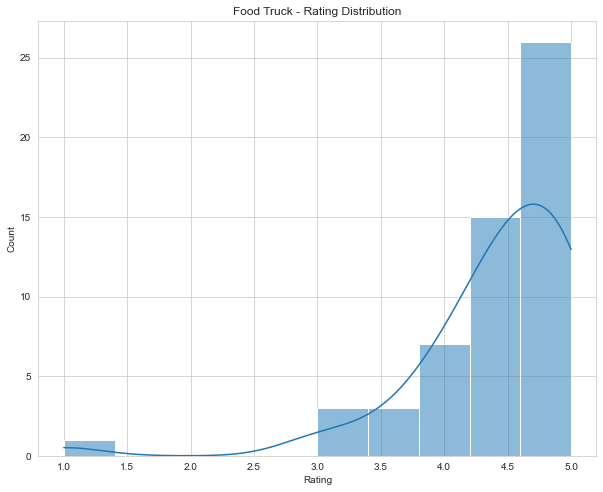

In [23]:
# Rating Distribution
plt.figure(figsize = (10,8))
sns.histplot(data=extract_df, x='rating', kde=True)
plt.title('Food Truck - Rating Distribution')
plt.xlabel('Rating')
plt.show()

As we can see, most of the ratings of the food trucks are atleast 3 stars.

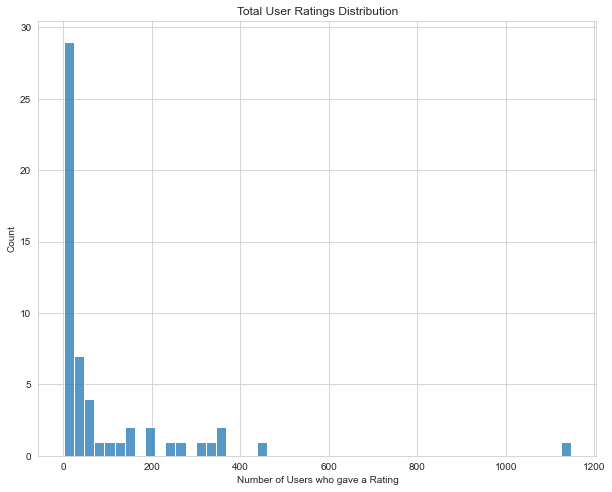

In [24]:
# Total User Ratings
plt.figure(figsize = (10,8))
sns.histplot(data=extract_df, x='user_ratings_total', bins=50)
plt.title('Total User Ratings Distribution')
plt.xlabel('Number of Users who gave a Rating')
plt.show()

The Number of Users who gave a Rating is highly skewed, with most restaurants having less than 10 users giving it a rating. However, we have few restaurants with close 1200 users giving it a rating.


-----------------

#### Food Truck - Operation Hours 

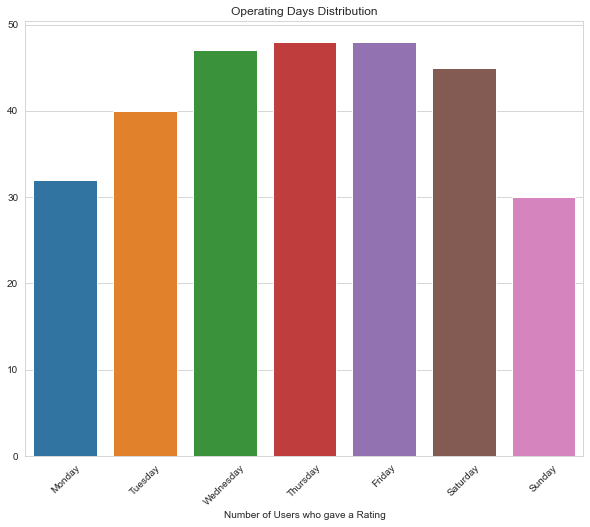

In [25]:
# Operating Days
plt.figure(figsize = (10,8))
days = ['Monday_is_open', 'Tuesday_is_open', 'Wednesday_is_open', 'Thursday_is_open', 'Friday_is_open', 'Saturday_is_open', 'Sunday_is_open']
days_total = extract_df[days].sum()
days_total.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.barplot(x=days_total.index, y=days_total.values)
plt.title('Operating Days Distribution')
plt.xticks(rotation=45)
plt.xlabel('Number of Users who gave a Rating')
plt.show()

Most of the food trucks are highly active during Weekdays - Wednesday through Friday, and the least active on Sunday and Monday although around half of the trucks are active on Sundays and Mondays.

#### For popular days Thursday and Friday

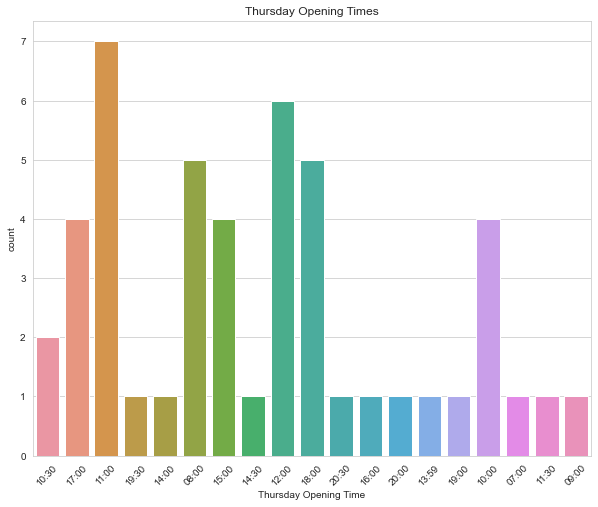

In [26]:
## Thursday Operating Hours
plt.figure(figsize = (10,8))
sns.countplot(data=extract_df, x='Thursday_open_time')
plt.title('Thursday Opening Times')
plt.xlabel("Thursday Opening Time")
plt.xticks(rotation=45)
plt.show()

On Thursdays, most Food trucks open at 11:00 AM and 12 PM, which indicates they do serve lunch!

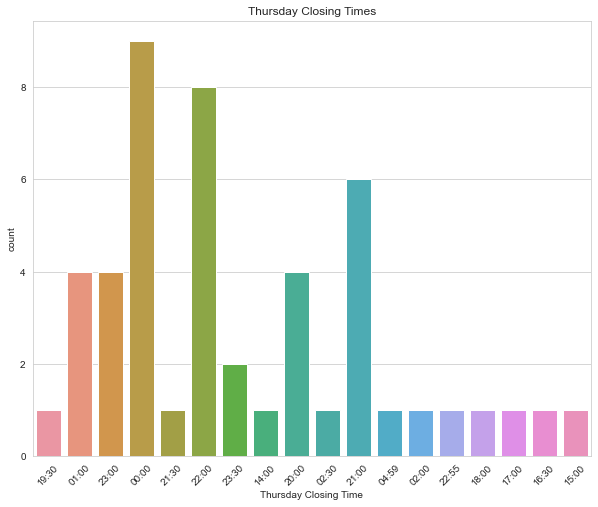

In [27]:
## Thursday Operating Hours
plt.figure(figsize = (10,8))
sns.countplot(data=extract_df, x='Thursday_close_time')
plt.title('Thursday Closing Times')
plt.xlabel("Thursday Closing Time")
plt.xticks(rotation=45)
plt.show()

On Thursdays, most Food trucks close at 12:00 AM and 10 PM, followed closely by 9 PM closing times.

-----------------------

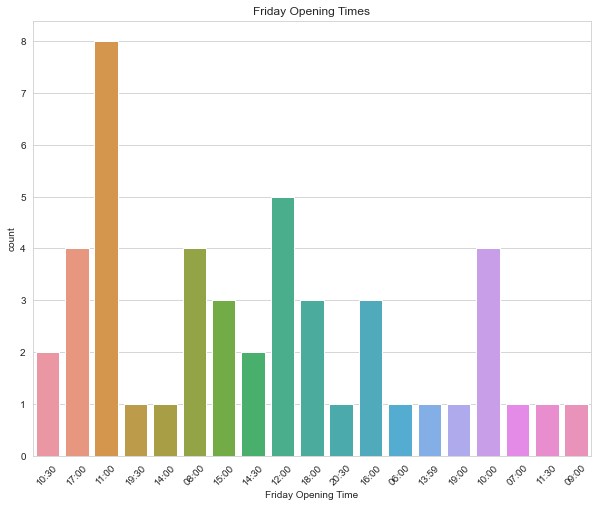

In [28]:
## Friday Operating Hours
plt.figure(figsize = (10,8))
sns.countplot(data=extract_df, x='Friday_open_time')
plt.title('Friday Opening Times')
plt.xlabel("Friday Opening Time")
plt.xticks(rotation=45)
plt.show()

On Fridays, most Food trucks open at 11:00 AM and 12 PM.

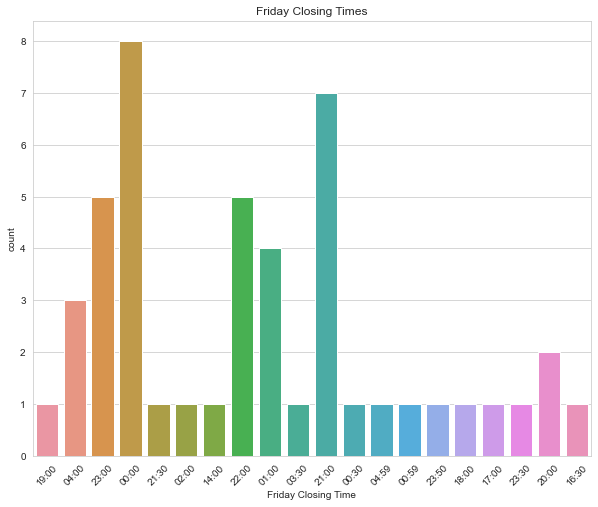

In [29]:
## Friday Operating Hours
plt.figure(figsize = (10,8))
sns.countplot(data=extract_df, x='Friday_close_time')
plt.title('Friday Closing Times')
plt.xlabel("Friday Closing Time")
plt.xticks(rotation=45)
plt.show()

On Fridays, most Food trucks close at 12:00 AM and 9 PM, followed closely by 10 PM (which is the opposite as we saw for Thursday)

-----------------

#### Food Trucks - Locations and Ratings

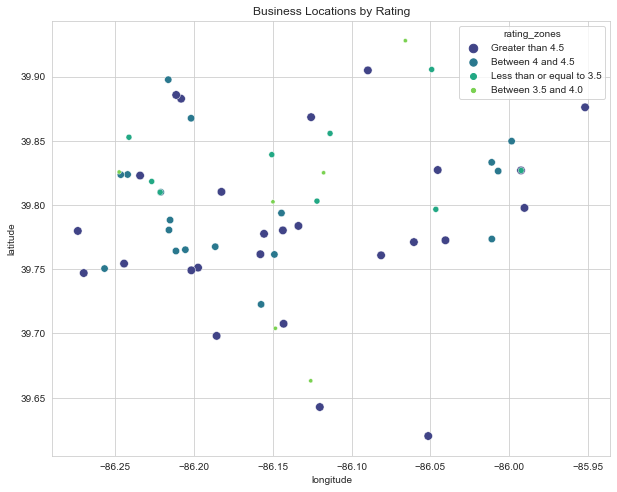

In [30]:
plt.figure(figsize = (10,8))
sns.scatterplot(data=extract_df, x='longitude', y='latitude', hue='rating_zones', palette='viridis', size='rating_zones')
plt.title('Business Locations by Rating')
plt.show()

As we saw with the histogram, most of the food trucks here have a rating of atleast 4.0! However, there are no specific clusters we can see, like a cluster of all 4.5+ food trucks, they are quite spread out.

#### Food Trucks - Reachability

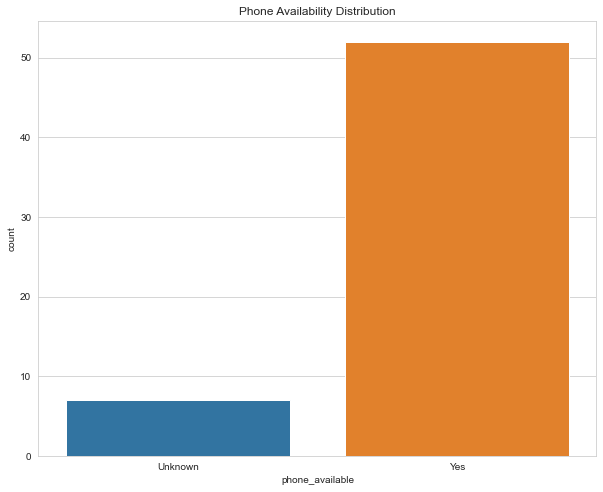

In [31]:
# Phone Availability
plt.figure(figsize = (10,8))
sns.countplot(data=extract_df, x='phone_available')
plt.title('Phone Availability Distribution')
plt.xticks(ticks=[0,1], labels=["Unknown", "Yes"])
plt.show()

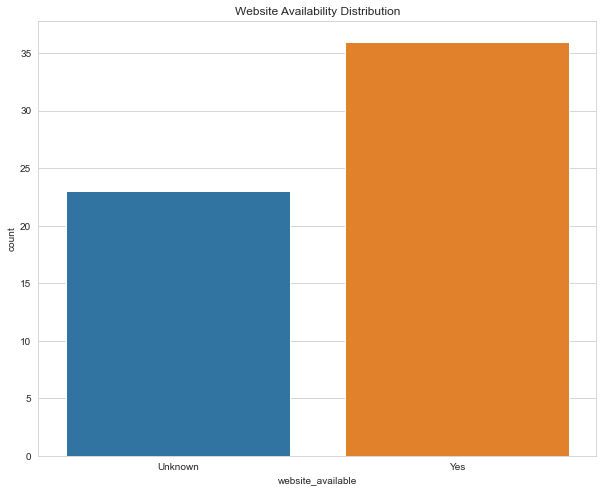

In [32]:
# Website Availability
plt.figure(figsize = (10,8))
sns.countplot(data=extract_df, x='website_available')
plt.title('Website Availability Distribution')
plt.xticks(ticks=[0,1], labels=["Unknown", "Yes"])
plt.show()

We can observe from the plots, that most food trucks are reachable via phone, but quite a few of them do not have a website.

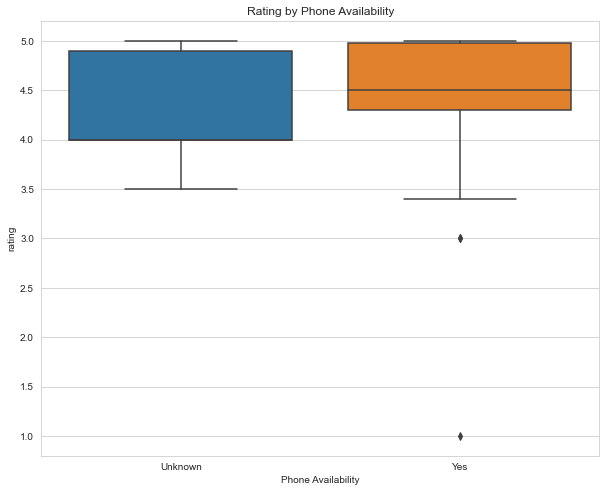

In [33]:
# Rating vs Phone availability
plt.figure(figsize = (10,8))
sns.boxplot(data=extract_df, x='phone_available', y='rating')
plt.title('Rating by Phone Availability')
plt.xlabel("Phone Availability")
plt.xticks(ticks=[0,1], labels=["Unknown", "Yes"])
plt.show()

The presence or lack of phone, does not seem to differentiate in terms of rating, which means we have to sometimes just show up to the food truck to enjoy the food!

------------------

#### Food Trucks - Cuisines

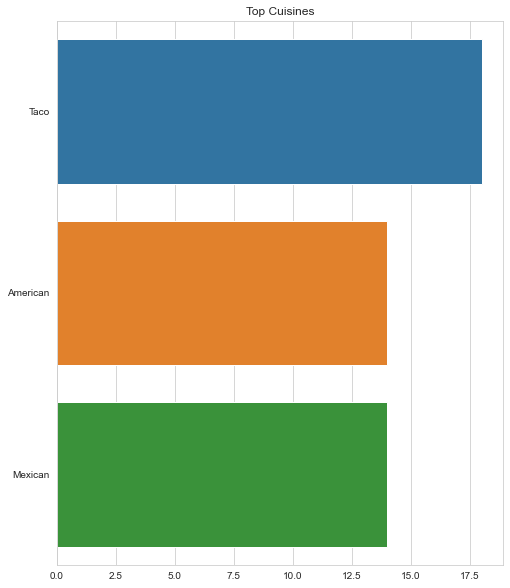

In [34]:
# Popular Cuisines
plt.figure(figsize = (8,10))
top_cuisines = extract_df['Cuisine'].value_counts().head(3)  # Top 3 cuisines
sns.barplot(x=top_cuisines.values, y=top_cuisines.index)
plt.title('Top Cuisines')
plt.show()

Top 3 Cuisines in Indianapolis are Tacos, American followed by Mexican, so a lot of options there!

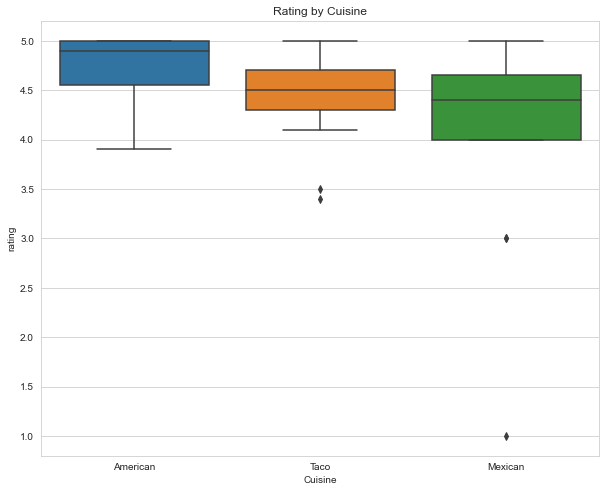

In [35]:
# Ratings by Cuisine
plt.figure(figsize = (10,8))
sns.boxplot(data=extract_df[(extract_df['Cuisine']=='Taco')|(extract_df['Cuisine']=='American')|(extract_df['Cuisine']=='Mexican')], x='Cuisine', y='rating')
plt.title('Rating by Cuisine')
plt.xticks(rotation=0)
plt.show()

Out of the top three cuisines, American Food Trucks seem to have a higher rating followed by Taco and then Mexican, with the latter two having some very low ratings as well.

-----------------------

#### Food Trucks - Best Rated

In [36]:
extract_df[(extract_df['rating'] > 4.5) & (extract_df['user_ratings_total'] > 20)][['name', 'rating']].reset_index(drop=True)

,name,rating
0,ClusterTruck,4.8
1,Emergency Taco Truck,4.7
2,Tacos El Iturbidense,4.7
3,King gyros food truck,4.7
4,ClusterTruck - Castleton,4.9
5,Birrieria Iturbidense,4.7
6,Tacos Tierra caliente Restaurant,4.8
7,ClusterTruck - Broad Ripple,4.9
8,Romeo's Kitchen|California|Best Indian Food Tr...,5.0
9,Gaucho's Fire Express,4.7


The Food Trucks which are the best rated and have atleast 20 ratings are displayed above. The highest rated is Romeo's Kitchen which seems like an Indian Food Truck.

---------------------

### Planning

#### Developing a basic Recommender System based on User Input which gives us the best food trucks to visit on the weekend.

In [37]:
user_prefs = {
    'cuisine_types': ['Mexican', 'Taco'],
    'ratings_count': 10,
    'meal_times': {
        'Saturday': ('12:00 PM', '5:00 PM'),
        'Sunday': ('1:00 PM', '5:00 PM')
    }
}

In [38]:
# Convert time to 24-hour format
def to_24_hour_format(time_str):
    if(len(time_str.split(' '))==2):
        return datetime.strptime(time_str, '%I:%M %p').strftime('%H:%M')
    
    return datetime.strptime(time_str, '%H:%M').strftime('%H:%M')

In [39]:
def basic_recommender(user_prefs, df):
   # 1. Filter based on ratings and number of ratings
    rating_threshold = user_prefs.get('rating', 4.0)
    cuisine_type = user_prefs.get('cuisine_types', 'American')
    ratings_count_threshold = user_prefs.get('ratings_count', 20)
    
    filtered_df_rating = df[(df['rating'] >= rating_threshold) & df['Cuisine'].isin(cuisine_type)]
    n_saturday = len(user_prefs.get('meal_times')['Saturday'])
    n_sunday = len(user_prefs.get('meal_times')['Sunday'])

    # 2a. Filter for Saturday
    saturday_filtered = filtered_df_rating[(filtered_df_rating['Saturday_open_time'].notna())]
    saturday_filtered = saturday_filtered[
        (saturday_filtered['user_ratings_total']>=ratings_count_threshold) &
        (saturday_filtered['Saturday_open_time'].apply(to_24_hour_format) <= to_24_hour_format(user_prefs['meal_times']['Saturday'][1])) & 
        (saturday_filtered['Saturday_close_time'].apply(to_24_hour_format) >= to_24_hour_format(user_prefs['meal_times']['Saturday'][0]))
    ]
    
    saturday_filtered['Day'] = 'Saturday'
    saturday_filtered.sort_values(by = 'rating', ascending = True, inplace = True)
    saturday_filtered = saturday_filtered[:n_saturday]

    # 2b. Filter for Sunday
    sunday_filtered = filtered_df_rating[(filtered_df_rating['Sunday_open_time'].notna())]
    sunday_filtered = sunday_filtered[
        ~sunday_filtered['name'].isin(saturday_filtered['name']) &
        (sunday_filtered['Sunday_open_time'].apply(to_24_hour_format) <= to_24_hour_format(user_prefs['meal_times']['Sunday'][1])) & 
        (sunday_filtered['Sunday_close_time'].apply(to_24_hour_format) >= to_24_hour_format(user_prefs['meal_times']['Sunday'][0]))
    ]
    
    sunday_filtered['Day'] = 'Sunday'
    sunday_filtered.sort_values(by = 'rating', ascending = True, inplace = True)
    sunday_filtered = sunday_filtered[:n_sunday]
    
    # Concatenate both results
    combined_filtered = pd.concat([saturday_filtered, sunday_filtered])

    return combined_filtered[['name', 'rating', 'formatted_phone_number', 'formatted_address', 'Cuisine', 'Day']]

In [40]:
recommendations = basic_recommender(user_prefs, extract_df)
recommendations

,name,rating,formatted_phone_number,formatted_address,Cuisine,Day
2,The Latin Flavor - Food Truck,4.1,(317) 895-9259,"9130 E 38th St, Indianapolis, IN 46235, USA",Mexican,Saturday
38,Taqueria Mi Costa,4.3,(317) 937-5828,"1430 W Washington St, Indianapolis, IN 46222, USA",Taco,Saturday
39,Taqueria El Taco Loco,4.4,(317) 910-5930,"2705 W Washington St, Indianapolis, IN 46222, USA",Taco,Sunday
47,Taqueria Los Potrillos,4.5,(317) 654-6821,"8925 42nd St, Indianapolis, IN 46226, USA",Mexican,Sunday


#### Note: 
The recommendation is a basic implementation of recommendation system which gives out the best rated restaurants considering number of ratings threshold and times when the food trucks are open, without considering distance. The goal of the recommender system is to visit the best restaurants based on cuisine.

Additionally, notice that there is no threshold of number of ratings on Sunday, because as we saw from our analysis, the number of food trucks on Sundays almost becomes the half thus we are already having restrictions there.

###### Limitations:
The recommender system will throw errors and might not give the right results with extreme timings and cuisines like Sunday 9:00 AM or Cuisine = Ethiopian will give results which are incorrect or no results at all.

However, with the right timings and cuisine we can have very good results.

-------------------------

### Visualization of Route:

In [41]:
saturday_plan = extract_df[extract_df['name'].isin(recommendations[(recommendations['Day']=='Saturday')]['name'])]
saturday_plan['coordinates'] = list(zip(saturday_plan.latitude, saturday_plan.longitude))
saturday_plan

C:\Users\ssara\AppData\Local\Temp/ipykernel_39112/734778964.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  saturday_plan['coordinates'] = list(zip(saturday_plan.latitude, saturday_plan.longitude))


,business_status,formatted_address,formatted_phone_number,name,rating,reviews,user_ratings_total,website,Cuisine,latitude,longitude,Monday_is_open,Tuesday_is_open,Wednesday_is_open,Thursday_is_open,Friday_is_open,Saturday_is_open,Sunday_is_open,Monday_open_time,Tuesday_open_time,Wednesday_open_time,Thursday_open_time,Friday_open_time,Saturday_open_time,Sunday_open_time,Monday_close_time,Tuesday_close_time,Wednesday_close_time,Thursday_close_time,Friday_close_time,Saturday_close_time,Sunday_close_time,phone_available,website_available,rating_zones,coordinates
2,OPERATIONAL,"9130 E 38th St, Indianapolis, IN 46235, USA",(317) 895-9259,The Latin Flavor - Food Truck,4.1,"[{'author_name': 'Drew “The Legend” Davis', 'a...",47.0,http://thelatinflavorindy.com/?utm_source=gmb&...,Mexican,39.826394,-86.006840,1,1,1,1,1,1,1,11:00,11:00,11:00,11:00,11:00,11:00,11:00,22:00,22:00,22:00,23:00,23:00,23:00,22:00,1,1,Between 4 and 4.5,"(39.8263944, -86.0068405)"
38,OPERATIONAL,"1430 W Washington St, Indianapolis, IN 46222, USA",(317) 937-5828,Taqueria Mi Costa,4.3,"[{'author_name': 'Mark Salcedo', 'author_url':...",202.0,https://taqueria-mi-costa.business.site/,Taco,39.767548,-86.186614,0,1,1,1,1,1,1,None,11:00,11:00,11:00,11:00,11:00,12:00,None,23:00,23:00,23:00,23:00,23:00,23:00,1,1,Between 4 and 4.5,"(39.767548, -86.18661449999999)"


In [42]:
saturday_plan_coords = saturday_plan[['name', 'latitude', 'longitude']]
saturday_plan_coords

,name,latitude,longitude
2,The Latin Flavor - Food Truck,39.826394,-86.006840
38,Taqueria Mi Costa,39.767548,-86.186614


In [43]:
import folium
import polyline

In [44]:
# Your Google Maps API Key
API_KEY = "API_Key"


# Define the starting point, end point, and waypoints
start_point = "39.7724,-86.1855"  # IUPUI
waypoints = [
    "39.8263944,-86.0860405",  # The Latin Flavor - Food Truck
    "39.767548,-86.18661499999999"  # Taqueria Mi Costa
]

# Build the API request URL
waypoint_str = "|".join(waypoints)
url = f"https://maps.googleapis.com/maps/api/directions/json?origin={start_point}&destination={start_point}&waypoints=optimize:true|{waypoint_str}&key={API_KEY}"

# Make the request
response = requests.get(url)
data = response.json()

# Extract the route (polyline) from the response
route_polyline = data['routes'][0]['overview_polyline']['points']
decoded_route = polyline.decode(route_polyline)

# Create a folium map centered around IUPUI
m = folium.Map(location=[39.7724, -86.1855], zoom_start=13)

# Add a line to the map for the route
folium.PolyLine(decoded_route, color="blue", weight=2.5, opacity=1).add_to(m)

# Add markers for the start, waypoints, and end
folium.Marker([39.7724, -86.1855], tooltip="IUPUI", icon=folium.Icon(color="green")).add_to(m)
for waypoint in waypoints:
    lat, lon = map(float, waypoint.split(','))
    folium.Marker([lat, lon], icon=folium.Icon(color="red")).add_to(m)
    
m

-------------------

In [45]:
sunday_plan = extract_df[extract_df['name'].isin(recommendations[(recommendations['Day']=='Sunday')]['name'])]
sunday_plan['coordinates'] = list(zip(sunday_plan.latitude, sunday_plan.longitude))
sunday_plan

C:\Users\ssara\AppData\Local\Temp/ipykernel_39112/1665859945.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sunday_plan['coordinates'] = list(zip(sunday_plan.latitude, sunday_plan.longitude))


,business_status,formatted_address,formatted_phone_number,name,rating,reviews,user_ratings_total,website,Cuisine,latitude,longitude,Monday_is_open,Tuesday_is_open,Wednesday_is_open,Thursday_is_open,Friday_is_open,Saturday_is_open,Sunday_is_open,Monday_open_time,Tuesday_open_time,Wednesday_open_time,Thursday_open_time,Friday_open_time,Saturday_open_time,Sunday_open_time,Monday_close_time,Tuesday_close_time,Wednesday_close_time,Thursday_close_time,Friday_close_time,Saturday_close_time,Sunday_close_time,phone_available,website_available,rating_zones,coordinates
39,OPERATIONAL,"2705 W Washington St, Indianapolis, IN 46222, USA",(317) 910-5930,Taqueria El Taco Loco,4.4,"[{'author_name': 'Chitwood Media', 'author_url...",360.0,http://www.facebook.com/El-Volkan-Mexican-Rest...,Taco,39.765211,-86.205599,1,1,1,1,1,1,1,17:00,17:00,17:00,11:00,11:00,11:00,17:00,22:55,22:55,22:55,22:55,23:50,23:50,22:55,1,1,Between 4 and 4.5,"(39.7652112, -86.2055986)"
47,OPERATIONAL,"8925 42nd St, Indianapolis, IN 46226, USA",(317) 654-6821,Taqueria Los Potrillos,4.5,"[{'author_name': 'allison baker', 'author_url'...",69.0,NaN,Mexican,39.833197,-86.010960,1,1,1,1,1,1,1,11:30,11:30,11:30,11:30,11:30,11:30,15:00,22:00,22:00,22:00,22:00,23:30,23:30,23:00,1,-1,Between 4 and 4.5,"(39.8331972, -86.0109597)"


In [46]:
sunday_plan_coords = sunday_plan[['name', 'latitude', 'longitude']]
sunday_plan_coords

,name,latitude,longitude
39,Taqueria El Taco Loco,39.765211,-86.205599
47,Taqueria Los Potrillos,39.833197,-86.010960


In [47]:
# Your Google Maps API Key
API_KEY = "API_Key"


# Define the starting point, end point, and waypoints
start_point = "39.7724,-86.1855"  # IUPUI
waypoints = [
    "39.765211, -86.205599",  # Taqueria El Taco Loco
    "39.833197, -86.010960"  # Taqueria Los Potrillos
]

# Build the API request URL
waypoint_str = "|".join(waypoints)
url = f"https://maps.googleapis.com/maps/api/directions/json?origin={start_point}&destination={start_point}&waypoints=optimize:true|{waypoint_str}&key={API_KEY}"

# Make the request
response = requests.get(url)
data = response.json()

# Extract the route (polyline) from the response
route_polyline = data['routes'][0]['overview_polyline']['points']
decoded_route = polyline.decode(route_polyline)

# Create a folium map centered around IUPUI
m = folium.Map(location=[39.7724, -86.1855], zoom_start=13)

# Add a line to the map for the route
folium.PolyLine(decoded_route, color="blue", weight=2.5, opacity=1).add_to(m)

# Add markers for the start, waypoints, and end
folium.Marker([39.7724, -86.1855], tooltip="IUPUI", icon=folium.Icon(color="green")).add_to(m)
for waypoint in waypoints:
    lat, lon = map(float, waypoint.split(','))
    folium.Marker([lat, lon], icon=folium.Icon(color="red")).add_to(m)
    
m

-------------------

### Conclusion:

After leveraging the Google API, I have compiled a dataset of 59 food trucks in Indianapolis. The data encompasses essential information, such as name, address, rating, website, opening hours, and cuisine type.

Our findings indicate:

Popularity: The average rating of food trucks in the city is 4.4 out of 5, suggesting that the food truck scene is thriving and well-received by customers.

Diversity: We observed that there's a wide variety of cuisines offered, with Mexican, American, and Taco food trucks being the most popular in number. This diversity ensures that there's something for everyone, catering to a wide range of palates.

Operating Hours: A majority of the food trucks operate between 11 AM to 8 PM, making lunch the optimal time for a food truck hop.

Based on this information, I have curated a two-day weekend foodie plan. The schedule ensures minimal travel time between stops and highlights the top-rated food trucks with diverse cuisines. We've also visualized the travel route to ensure a seamless food adventure.

In conclusion, the data emphasizes the richness of the Indianapolis food truck sceneand ensures that we only experience the best food from the best food trucks!